# House Prices Analysis
### Danielle Rokni
<drokni88@gmail.com>

The aim of this project is to predict what a house's salling price is, based on a set of given features.

The data was obtained from Kaggle, and contains 79 explanatory variables describing every aspect of residential homes in Ames, Iowa.

## Import Libraries

In [863]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from scipy import stats
from statsmodels.formula.api import ols
from time import time
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LassoCV 
import warnings
warnings.filterwarnings('ignore')

## Functions

In [864]:
def load_data(file_path):
    return pd.read_csv(file_path, sep=",")

def log_transformation(df, features, target, not_test):
    transformed_features=[]
    
    for feat in features:
        if df[feat].describe().at['min']==0:
            df[feat]=df[feat]+1
        heading=feat+u"_"+u'log'
        df[heading]=np.log(df[feat])
        df.drop(feat, inplace=True, axis=1)
        transformed_features.append(heading)
        
    #move target to last column
    if (not_test):
        temp_y=df.pop(target) 
        df[target]=temp_y

    return df, transformed_features

def create_bin(df, features, target, not_test):
    for feat in features:
        heading="Bin"+u"_"+feat
        df[heading]=pd.Series(len(df[feat]), index=df.index)
        df[heading]=0
        df.loc[df[feat]==0 , heading]=1
        df[heading]=df[heading].astype(object)
        
    #move target to last column
    if (not_test):
        temp_y=df.pop(target) 
        df[target]=temp_y
        
    return df

def create_dummies(df, target, not_test):
    df=pd.get_dummies(df)
     
   #move target to last column
    if (not_test):
        temp_y=df.pop(target) 
        df[target]=temp_y

    return df
        
def run_lr(train_X, train_Y, test_X):
    clf=Lasso()

    param_grid={
            'alpha': [1, 0.1, 0.01, 0.001, 0.0005]
    }

    lr_grid=GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=2)

    start=time()

    lr_grid.fit(train_X, train_Y)

    print("LR GridSearchCV took %.2f seconds."% (time()-start))

    lr_best_model=lr_grid.best_estimator_
    lr_predictions=lr_best_model.predict(test_X)
    
    return lr_predictions, lr_best_model
    
def run_rf(train_X, train_Y, test_X):
    clf=RandomForestRegressor()
    
    n_estimators=[int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    max_features=['auto', 'sqrt']

    param_dist={
            'n_estimators': n_estimators,
            'max_features': max_features
    }

    rf_random=RandomizedSearchCV(estimator=clf, param_distributions=param_dist, n_iter=4, n_jobs=-1,
                                 scoring='neg_mean_squared_error', cv=2)

    start=time()

    rf_random.fit(train_X, train_Y)

    print("RF RandomizedSearchCV took %.2f seconds."% (time()-start))

    rf_best_model=rf_random.best_estimator_
    rf_predictions=rf_best_model.predict(test_X)
    
    return rf_predictions, rf_best_model
    
def run_xgb(train_X, train_Y, test_X):
    clf=xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, silent=True, nthread=1)

    params={
            'min_child_weight': [1, 5, 10],
            'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
    }

    xgb_random=RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=5, n_jobs=1, 
                                  scoring='neg_mean_squared_error', cv=2)

    start=time()

    xgb_random.fit(train_X, train_Y)

    print("XGB RandomizedSearchCV took %.2f seconds."% (time()-start))

    xgb_best_model=xgb_random.best_estimator_
    xgb_predictions=xgb_best_model.predict(test_X)
    
    return xgb_predictions, xgb_best_model

## Load train data

In [865]:
train=load_data('train.csv')
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Fill missing values
Let's look if there are missing values.

In [866]:
train[train.columns[train.isnull().any()].tolist()].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

We can spot a lot of missing values, but can we fill them? Let's look at each feature individually:
<ul>
    <li><em>'LotFrontage'</em>- Linear feet of street connected to property</li>
    <ul>
        <li>Can't be 0 (a property without access).</li>
        <li>If we assume that most lots are rectangular, maybe there is a connection with <em>'LotArea'</em>?</li>
        <li>If there is one, we can use it since <em>'LotArea'</em> has no missing value.</li>
        <li>We'll check correlations between the 2 features, and also a square root connection (<em>'LotFrontage'</em> is linear feet and <em>'LotArea'</em> is square feet).</li>
    </ul>
</ul>

In [867]:
print("LotFrontage'-'LotArea' correlation:", train['LotFrontage'].corr(train['LotArea']))
train['SqrtLotArea']=np.sqrt(train['LotArea'])
print("LotFrontage'-'SqrtLotArea' correlation:", train['LotFrontage'].corr(train['SqrtLotArea']))

LotFrontage'-'LotArea' correlation: 0.42609501877180816
LotFrontage'-'SqrtLotArea' correlation: 0.6020022167939364


<ul>
    <ul>
        <li>The correlation between <em>'LotFrontage'</em> and <em>'SqrtLotArea'</em> seems good enough for us to use it and fill all missing values of <em>'LotFrontage'</em> with the square root of <em>'LotArea'</em>.</li>
    </ul>
<ul>

In [868]:
train['LotFrontage']=np.where(train['LotFrontage'].isnull(), train['SqrtLotArea'], train['LotFrontage'])
train.drop('SqrtLotArea', axis=1, inplace=True)

<ul>
    <li><em>'Alley'</em>- Type of alley access to property</li>
    <ul>
        <li>'NA' stands for no alley access.</li>
        <li>Let's replace 'NA' values with 'None'.</li>
    </ul>
</ul>

In [869]:
train.loc[train['Alley'].isnull(), 'Alley']='None'

<ul>
    <li><em>'MasVnrType'</em>/<em>'MasVnrArea'</em>- Masonry veneer type / Masonry veneer area in square feet</li>
    <ul>
        <li>Both have 8 values missing, let's check if they are the same ones.</li>
    </ul>
</ul>

In [870]:
train[['MasVnrType','MasVnrArea']][train['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


<ul>
    <ul>
        <li>Let's check <em>'MasVnrType'</em> most frequent value.</li>
    </ul>
</ul>

In [871]:
train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

<ul>
    <ul>
        <li>The most frequent value of <em>'MasVnrType'</em> is 'None'.</li>
        <li>Respectively, let's set all missing values of <em>'MasVnrArea'</em> as 0.</li>
    </ul>
</ul>

In [872]:
train.loc[train['MasVnrType'].isnull(), 'MasVnrType']='None'
train.loc[train['MasVnrArea'].isnull(), 'MasVnrArea']=0.0

<ul>
    <li><em>'Bsmt...'</em> features- Features in connection with basement</li>
    <ul>
        <li>Let's check if missing values are in the same records for all features.</li>
        <li>There are 2 basement-related numerical features without missing values- <em>'BsmtFinSF1'</em> & <em>'BsmtFinSF2'</em>.</li>
        <li>We'll look at those, then decide what to do with the missing values.</li>
    </ul>
</ul>

In [873]:
basement_columns=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
train[basement_columns][train['BsmtQual'].isnull()==True]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
17,NaN,NaN,NaN,NaN,NaN,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0
182,NaN,NaN,NaN,NaN,NaN,0,0
259,NaN,NaN,NaN,NaN,NaN,0,0
342,NaN,NaN,NaN,NaN,NaN,0,0
362,NaN,NaN,NaN,NaN,NaN,0,0
371,NaN,NaN,NaN,NaN,NaN,0,0


<ul>
    <ul>
        <li>Where categorical features are 'NaN', numerical ones are 0, which means the property has no basement.</li>
        <li>Then missing values for categorical features should be set 'None'.</li>
    </ul>
</ul>

In [874]:
for column in basement_columns:
        if 'FinSF' not in column:
            train.loc[train[column].isnull(), column]='None'

<ul>
    <ul>
        <li><em>'BsmtFinType2'</em> had 1 more 'Nan' value then the others (we now set it to 'None').</li>
        <li>Let's check if the conversion was correct (accordint to the other <em>'Bsmt...'</em> features).</li>
    </ul>
</ul>

In [875]:
train[basement_columns].loc[(train['BsmtFinType2']=='None') & (train['BsmtQual']!='None')]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
332,Gd,TA,No,GLQ,None,1124,479


<ul>
    <ul>
        <li>Line 332- <em>'BsmtFinType2'</em> is 'None' but <em>'BsmtFinSF2'</em>>0, there is a second finished basement.</li>
        <li>Let's check <em>'BsmtFinType2'</em> most frequent value.</li>
    </ul>
</ul>

In [876]:
train['BsmtFinType2'].value_counts()

Unf     1256
Rec       54
LwQ       46
None      38
BLQ       33
ALQ       19
GLQ       14
Name: BsmtFinType2, dtype: int64

<ul>
    <ul>
        <li>We know that <em>'BsmtFinType2'</em> can't be 'Unf', we'll set it to the most frequent value after 'Unf', 'Rec'.</li>
    </ul>
</ul>

In [877]:
train.at[332, 'BsmtFinType2']='Rec'

<ul>
    <ul>
        <li><em>'BsmtExposure'</em> also had 1 more 'Nan' (which we also set to 'None').</li>
        <li>Let's check if the conversion was correct (accordint to the other <em>'Bsmt...'</em> features).</li>
    </ul>
</ul>

In [878]:
train[basement_columns].loc[(train['BsmtExposure']=='None') & (train['BsmtQual']!='None')]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
948,Gd,TA,None,Unf,Unf,0,0


<ul>
    <ul>
        <li>Line 948- <em>'BsmtExposure'</em> is 'None' but all other categorical features aren't.</li>
        <li>Let's check if in other cases where <em>'BsmtFinType1'</em> & <em>'BsmtFinType2'</em> are 'Unf', <em>'BsmtExposure'</em> is 'None'.</li>
    </ul>
</ul>

In [879]:
train[basement_columns].loc[(train['BsmtFinType1']=='Unf') & (train['BsmtFinType2']=='Unf')]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
8,TA,TA,No,Unf,Unf,0,0
13,Gd,TA,Av,Unf,Unf,0,0
15,TA,TA,No,Unf,Unf,0,0
20,Ex,TA,Av,Unf,Unf,0,0
21,TA,TA,No,Unf,Unf,0,0
22,Gd,TA,No,Unf,Unf,0,0
25,Gd,TA,No,Unf,Unf,0,0
29,TA,TA,No,Unf,Unf,0,0
30,TA,TA,No,Unf,Unf,0,0
31,TA,TA,No,Unf,Unf,0,0


<ul>
    <ul>
        <li>In all other cases <em>'BsmtExposure'</em> isn't 'None'.</li>
        <ul>Let's check <em>'BsmtFinType2'</em> most frequent value whree both <em>'BsmtFinType1'</em> & <em>'BsmtFinType2'</em> are 'Unf'.</li>
    </ul>
</ul>

In [880]:
tmp=train[basement_columns].loc[(train['BsmtFinType1']=='Unf') & (train['BsmtFinType2']=='Unf')]
tmp['BsmtExposure'].value_counts()

No      345
Av       46
Mn       27
Gd       11
None      1
Name: BsmtExposure, dtype: int64

<ul>
    <ul>
        <li>The most frequent value of <em>'BsmtExposure'</em> is 'No'.</li>
    </ul>
</ul>

In [881]:
train.at[948, 'BsmtExposure']='No'

<ul>
    <li><em>'Electrical'</em>- Electrical system</li>
    <ul>
        <li>Can't be 'NaN' (a property without electrical system).</li>
        <li>There is one missing value, let's set it to the most frequent value.</li>
    </ul>
</ul>

In [882]:
train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

<ul>
    <ul>
        <li>The most frequent value of <em>'Electrical'</em> is 'SBrkr'.</li>
    </ul>
</ul>

In [883]:
train.loc[train['Electrical'].isnull(), 'Electrical']='SBrkr'

<ul>
    <li><em>'FireplaceQu'</em>- Fireplace quality</li>
    <ul>
        <li>Presumably properties without a fireplace.</li>
        <li>Let's check if the feature <em>'Fireplaces'</em> has values larger than 0 where <em>'FireplaceQu'</em> has 'Nan'.</li>
    </ul>
</ul>

In [884]:
descriptive=train['Fireplaces'][train['FireplaceQu'].isnull()==True].describe()
print("min: {min:.3f}\nmax: {max:.3f}".format(min=descriptive.at['min'],max=descriptive.at['max']))

min: 0.000
max: 0.000


<ul>
    <ul>
        <li>Whenever <em>'FireplaceQu'</em> is 'Nan', there are no fireplaces in the proprty.</li>
        <li>Let's set the missing values to 'None'.</li>
    </ul>
</ul>

In [885]:
train.loc[train['FireplaceQu'].isnull(), 'FireplaceQu']='None'
pd.crosstab(train.Fireplaces, train.FireplaceQu)

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


<ul>
    <li><em>'Garage...'</em> features- Features in connection with garage</li>
    <ul>
        <li>All have 81 missing values.</li>
        <li>There are 2 garage-related numerical features without missing values- <em>'GarageCars'</em> & <em>'GarageArea'</em>.</li>
        <li>We'll look at those, then decide what to do with the missing values.</li>
    </ul>
</ul>

In [886]:
garage_columns=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
train[garage_columns][train['GarageType'].isnull()==True] 

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
127,NaN,NaN,NaN,NaN,NaN,0,0
140,NaN,NaN,NaN,NaN,NaN,0,0


<ul>
    <ul>
        <li>All missing values are on the same records.</li>
        <li>Where categorical features are 'NaN', numerical ones are 0, which means the property has no garage.</li>
        <li>Then missing values for categorical features should be set 'None'.</li>
    </ul>
</ul>

In [887]:
for column in garage_columns:
        if train[column].dtype==np.object:
            train.loc[train[column].isnull(), column]='None'
        else:
            train.loc[train[column].isnull(), column]=0

<ul>
    <li><em>'PoolQC'</em>- Pool quality</li>
    <ul>
        <li>Presumably properties without a pool.</li>
        <li>Let's check if the feature <em>'PoolArea'</em> has values larger than 0 where <em>'PoolQC'</em> has 'Nan'.</li>
    </ul>
</ul>

In [888]:
descriptive=train['PoolArea'][train['PoolQC'].isnull()==True].describe()
print("min: {min:.3f}\nmax: {max:.3f}".format(min=descriptive.at['min'],max=descriptive.at['max']))

min: 0.000
max: 0.000


<ul>
    <ul>
        <li>Whenever <em>'PoolQC'</em> is 'Nan', there is no pool in the proprty.</li>
        <li>Let's set the missing values to 'None'.</li>
    </ul>
</ul>

In [889]:
train.loc[train['PoolQC'].isnull(), 'PoolQC']='None'
pd.crosstab(train.PoolArea, train.PoolQC)

PoolQC,Ex,Fa,Gd,None
PoolArea,,,,
0,0,0,0,1453
480,0,0,1,0
512,1,0,0,0
519,0,1,0,0
555,1,0,0,0
576,0,0,1,0
648,0,1,0,0
738,0,0,1,0


<ul>
    <li><em>'Fence'</em>- Fence quality</li>
    <ul>
        <li>'NA' stands for no fence.</li>
        <li>Let's replace 'NA' values with 'None'.</li>
    </ul>
</ul>

In [890]:
train.loc[train['Fence'].isnull(), 'Fence']='None'

<ul>
    <li><em>'MiscFeature'</em>- Miscellaneous feature not covered in other categories</li>
    <ul>
        <li>Presumably properties without a special feature.</li>
        <li>There is 1 miscellaneous-related numerical feature without missing values- <em>'MiscVal'</em> & <em>.</li>
        <li>We'll look at it, then decide what to do with the missing values.</li>
    </ul>
</ul>

In [891]:
descriptive=train['MiscVal'][train['MiscFeature'].isnull()==True].describe()
print("min: {min:.3f}\nmax: {max:.3f}".format(min=descriptive.at['min'],max=descriptive.at['max']))

min: 0.000
max: 0.000


<ul>
    <ul>
        <li>Whenever <em>'MiscFeature'</em> is 'Nan', there is no special feature in the proprty.</li>
        <li>Let's set the missing values to 'None'.</li>
    </ul>
</ul>

In [892]:
train.loc[train['MiscFeature'].isnull(), 'MiscFeature']='None'
pd.crosstab(train.MiscVal, train.MiscFeature)

MiscFeature,Gar2,None,Othr,Shed,TenC
MiscVal,,,,,
0,0,1406,1,1,0
54,0,0,0,1,0
350,0,0,0,1,0
400,0,0,0,11,0
450,0,0,0,4,0
480,0,0,0,2,0
500,0,0,0,8,0
560,0,0,0,1,0
600,0,0,0,4,0


<ul>
    <ul>
        <li>There is one property with a special feature worth 0 USD, sounds unlikely but the feature is unknown to us, we'll leave it as is.</li>
        <li>There is another property with a shed (over 100 SF) worth 0 USD, it is unlikely since other sheds are worth more.</li>
        <li>Let's check the average price for sheds.</li>
    </ul>
</ul>

In [893]:
round(train.loc[train['MiscFeature']=='Shed', 'MiscVal'].mean())

698

<ul>
    <ul>
        <li>The mean value of 'Shed' is 698.</li>
    </ul>
</ul>

In [894]:
train.loc[(train['MiscFeature']=='Shed') & (train['MiscFeature']=='Shed') & (train['MiscVal']==0), 'MiscVal']=698

We need to verify that we delt with all missing values.

In [895]:
train[train.columns[train.isnull().any()].tolist()].isnull().sum()
train_copy=train.copy()

All missing values have been filled.
## Validate features' dtypes
We need to make sure that all features are labeled properly as they should, according to what we know about them from the description.

In [896]:
train.get_dtype_counts()

int64      34
object     43
float64     3
dtype: int64

3 features, <em>'MSSubClass'</em>, <em>'OverallQual'</em>, and <em>'OverallCond'</em> are misslabeled as numerical.

In [897]:
train['MSSubClass']=train['MSSubClass'].astype(object)
train['OverallQual']=train['OverallQual'].astype(object)
train['OverallCond']=train['OverallCond'].astype(object)

Now all of the feauters are properly labeled.
## EDA for target
We'll start by understanding how the target variable <em>'SalePrice'</em> is distributed. 

In [898]:
target=train.columns[-1]
train[target].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

First of all we notice that the minimum value of <em>'SalePrice'</em> is larger than 0, there are no misstaged records that would sabotage potential models.

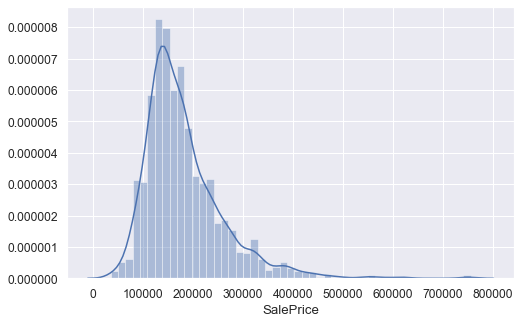

In [899]:
plt.figure(figsize=(8, 5))
sns.distplot(train[target])
plt.show(block=False)

We can see that the prices distribution is skewed to the right, <em>Log</em> transformation would bring the targets' distribution closer to normal, and since all values are positive it wouldn't be a problem to do so.
Even though the normal assumptions for reggresion models refer to the residuals (and not the target itself) it could potentially help us.

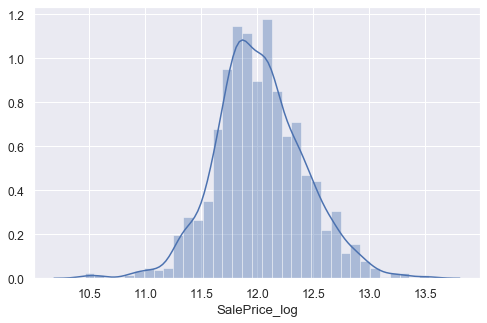

In [900]:
heading=target+u"_"+u'log'
train[heading]=np.log(train[target])
train.drop(target, inplace=True, axis=1)
target=heading

plt.figure(figsize=(8, 5))
sns.distplot(train[target])
plt.show(block=False)

## EDA for numerical features
We'll now look at the distribution of all numerical features, understant the connections between them, and the connection between each of them and <em>'SalePrice_log'</em> (our new target). 
### Descriptive statistics

In [901]:
train_num_features=train[train.columns[0 : -1]]._get_numeric_data().columns
train[train_num_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,76.644196,10516.828082,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.967123,6.321918,2007.815753
std,31.274670,9981.264932,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.417310,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,60.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,73.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,90.000000,11601.500000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,405.783193,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


### Histograms
Now let's plot them all.

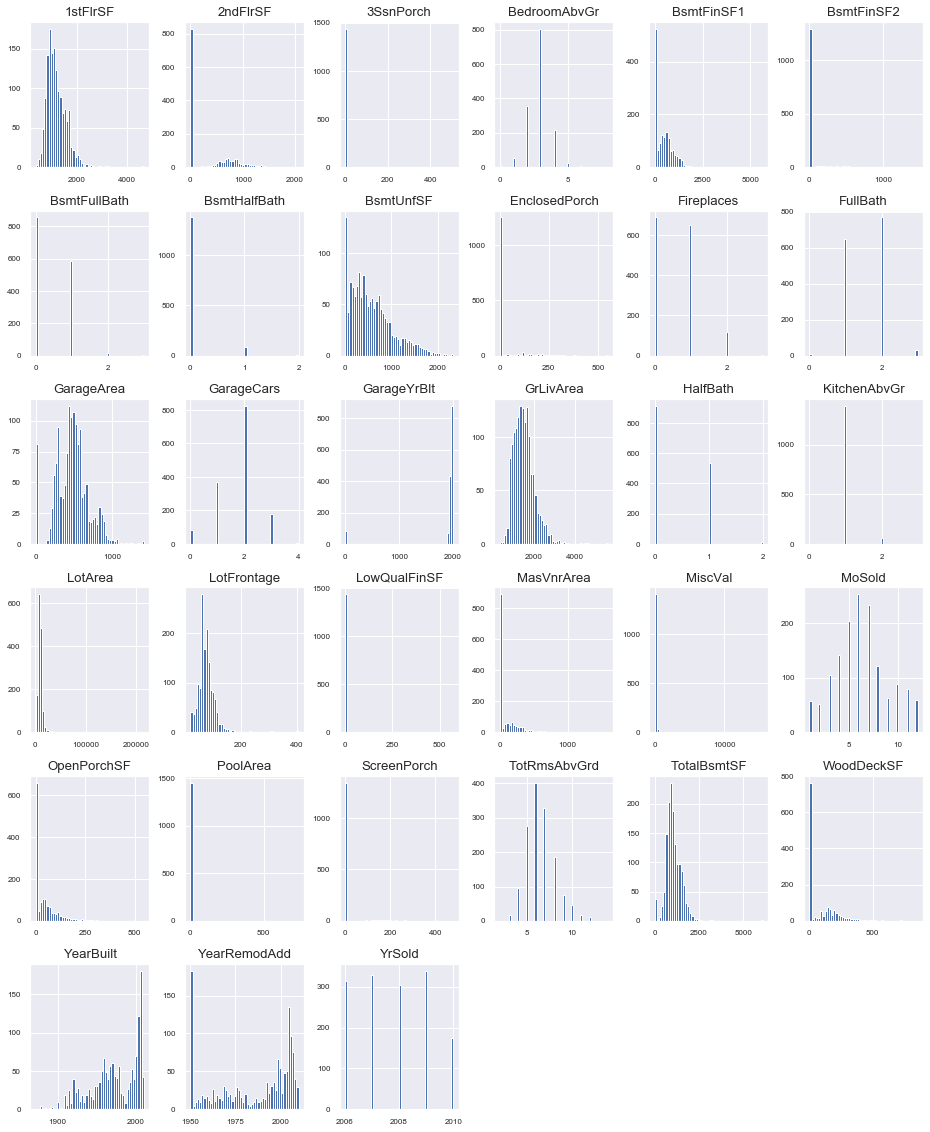

In [902]:
train[train_num_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show(block=False)

<ul>
    <li>Some feauters seem to share similar distribution with <em>'SalePrice'</em> (our old target), therefore performing a <em>Log</em> transformation would bring their distribution closer to the target which will help with modeling.</li>
    <li>In order to perform <em>Log</em> transformation, we first need to check which of these feautres contain 0 values, and if so properly tranforming the data.</li>
    <ul>
        <li>$Log(X)$ for features with all positive values.</li>
        <li>$Log(X+1)$ for features containig 0 values- that way <em>Log</em> transformation could be done, and 0 values before the transformation will remain 0 after it ($Log(1))$.</li>
    </ul>
    <li>There are 9 features with one very frequent value, almost singular. Those features contain no information on <em>'SalePrice'</em>, we'll remove them.</li>
</ul>

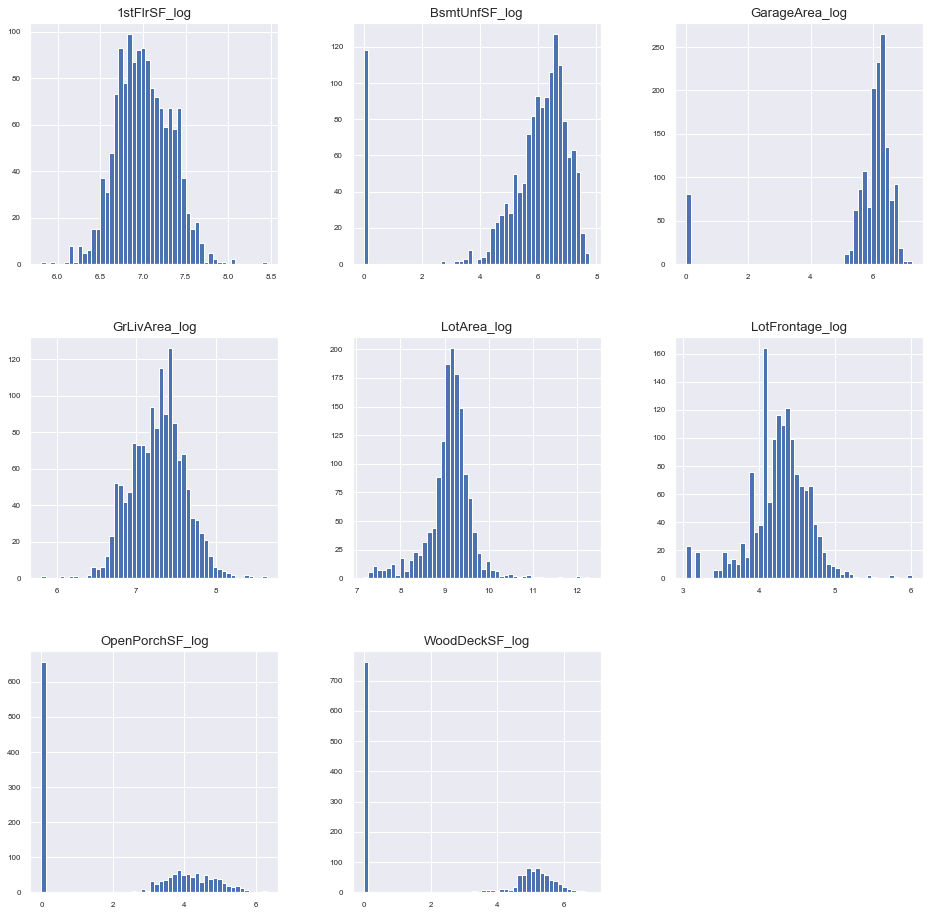

In [903]:
remove_features=['3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch', 'KitchenAbvGr', 'LowQualFinSF',
                   'MiscVal', 'PoolArea', 'ScreenPorch']
train.drop(remove_features, axis=1, inplace=True)

features=['LotFrontage', 'LotArea', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
train, transformed_features=log_transformation(train, features, target, True)

train[transformed_features].hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8)
plt.show(block=False)

In <em>'BsmtUnfSF'</em>, <em>'GarageArea'</em>, <em>'WoodDeckSF'</em>, and <em>'OpenPorchSF'</em> we see a large concentration of 0 values (that was there also before), but besides, the distribution seems more balanced.
We will deal with the zero-inflated features later.

### Connections between features & target
It's important to understand that all the information we can obtain here will only help increase our intuition about strong and simple relationships betwwen the numerical features and themselves, and between the numerical features and the target value.
Since the naked eye can't cope with a complexed visualization, we are flattening an 80D data into 2D, making it impossible to identify complicated relationships.
#### Pearson correlation
Can only evaluates a <b>linear</b> connection between 2 numeric variables.

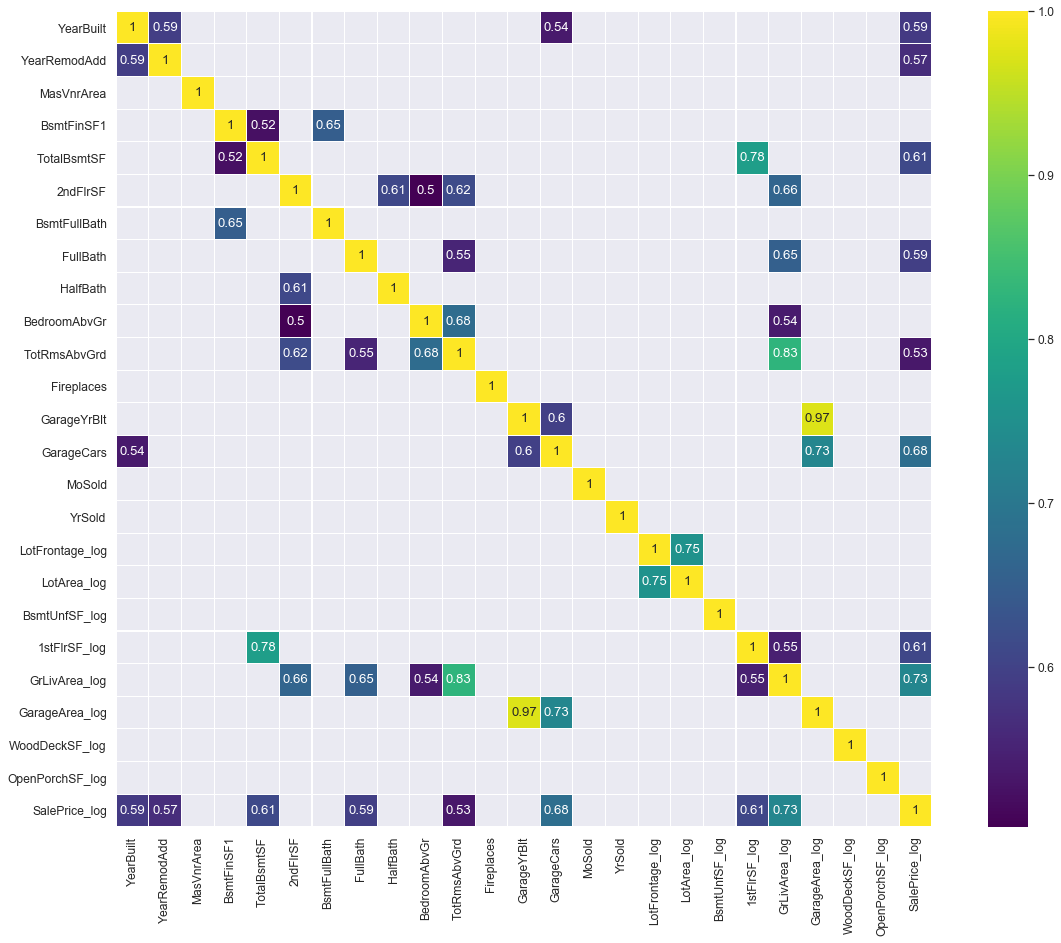

In [904]:
df_num=train.select_dtypes(include=['float64', 'int64'])
corr=df_num.corr() 
sns.set(font_scale=1.10)
plt.figure(figsize=(20, 15))
sns.heatmap(corr[(corr>=0.5) | (corr<=-0.4)], vmax=1.0, linewidths=0.1, square=True, annot=True, cmap='viridis', 
            linecolor="white")
plt.show(block=False)                                                                                 

First we can spot features with strong linear connection between them:
<ul>
    <li><em>'TotalBsmtSF'</em>-<em>'1stFlrSF'</em> (0.78)</li> It sounds possible that there is a connection between the size of the basement and the first floor (the floor above the badement).
    <li><em>'TotRmsAbvGrd'</em>-<em>'GrLivArea_log'</em> (0.83)</li> Sounds reasonable that ther is a connection between the number of rooms above grade and the above grade living area size. The more rooms there are, the bigger the size.
    <li><em>'GarageYrBlt'</em>-<em>'GarageArea_log'</em> (0.97)</li> It sounds possible that throughout the years there were demands for a bigger garage that would be able to feet more cars.
    <li><em>'GarageCars'</em>-<em>'GarageArea_log'</em> (0.73)</li> The number of cars that fit into the garage is a result of the garage area.
    <li><em>'LotFrontage_log'</em>-<em>'LotArea'</em> (0.75)</li> We knew about this relationship, we filled missing values based on it.
</ul>
Strongly correlated features can cause a problematic situation of multicollinearity, but although pearson correlation values are high, most of them are not that severe. We will let the models decide which ones to despose, since it seems like in each pair of features listed above one will not provide much more information than the other.
We will only remove either <em>'GarageYrBlt'</em> or <em>'GarageArea_log'</em>, because of the substantioal pearson correlation value. To decide which one, we will examine the correlation between each of them and <em>'SalePrice_log'</em>.

In [905]:
features=['GarageYrBlt', 'GarageArea_log', 'SalePrice_log']
tmp_df=[]
for i in range(0, len(df_num[features].columns)-1):
    tmp=df_num[[df_num[features].columns[i], 'SalePrice_log']]
    tmp_df.append(tmp)
corr_with_target={feature.columns[0]: feature.corr()['SalePrice_log'][0] for feature in tmp_df}
corr_with_target=sorted(corr_with_target.items(), key=operator.itemgetter(1))
for (key, value) in corr_with_target:
    print("{:>15}: {:>15}".format(key, value))

    GarageYrBlt: 0.3490136169886158
 GarageArea_log: 0.4548988247258098


We will remove <em>'GarageYrBlt'</em> fron the data frame (the correlation between it and <em>'SalePrice_log'</em> is smaller).

In [906]:
train.drop('GarageYrBlt', axis=1, inplace=True)

Another thing we can spot from the heat map is features with strong linear connection to the target.

In [907]:
df_num=train.select_dtypes(include=['float64', 'int64'])
corr_with_target=df_num.corr()[target][:-1]
corr_with_target[abs(corr_with_target)>0.5]

YearBuilt        0.586570
YearRemodAdd     0.565608
TotalBsmtSF      0.612134
FullBath         0.594771
TotRmsAbvGrd     0.534422
GarageCars       0.680625
1stFlrSF_log     0.608947
GrLivArea_log    0.730255
Name: SalePrice_log, dtype: float64

We know from looking at the feaures' histograms that there are a lot of features with high zero count. Let's, for a second, filter those 0 and check correlation with target again.

In [908]:
filtered_df=[]
for i in range(0, len(df_num.columns)-1):
    tmp=df_num[[df_num.columns[i], 'SalePrice_log']]
    tmp=tmp[tmp[df_num.columns[i]]!=0]
    filtered_df.append(tmp)
corr_with_target={feature.columns[0]: feature.corr()['SalePrice_log'][0] for feature in filtered_df}
corr_with_target=sorted(corr_with_target.items(), key=operator.itemgetter(1))
for (key, value) in corr_with_target:
    if abs(value)>0.5:
        print("{:>15}: {:>15}".format(key, value))

   TotRmsAbvGrd: 0.5344222037231195
   YearRemodAdd: 0.5656078325911801
      YearBuilt: 0.5865702403842262
    TotalBsmtSF: 0.596070758901754
       FullBath: 0.6065826478035251
   1stFlrSF_log: 0.608946654903631
 GarageArea_log: 0.6105570904635154
     GarageCars: 0.6537736491489563
       2ndFlrSF: 0.6821309517648297
  GrLivArea_log: 0.7302548511982293


We found 2 more features that have strong connection with target, when not accounting for zeroes- <em>'GarageArea_log'</em>, <em>'2ndFlrSF'</em>.
Let's create a dummy variable for each of that features, it will help deal individually with cases of zerpes.

In [909]:
features=['GarageArea_log', '2ndFlrSF']
train=create_bin(train, features, target, True)

#### Bivariate scatter plots
The last thing we'll want to do for this part is too look at bivariate scatter plot, in order to maybe recognize more 2D relationships between the features and the target.

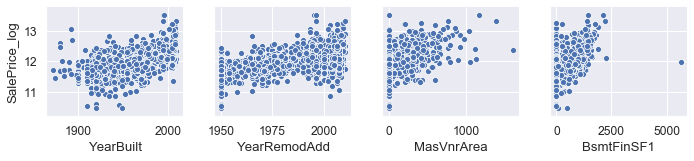

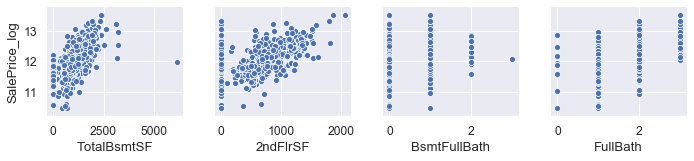

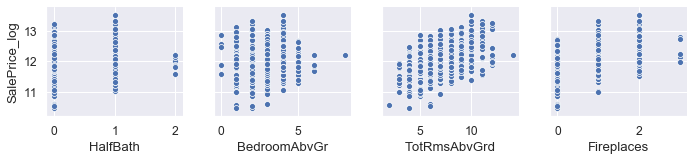

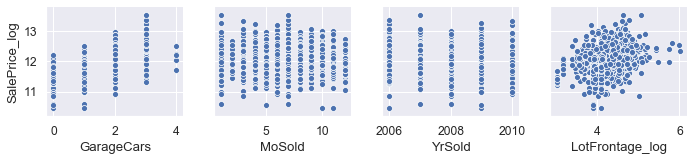

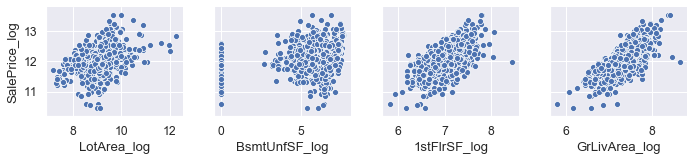

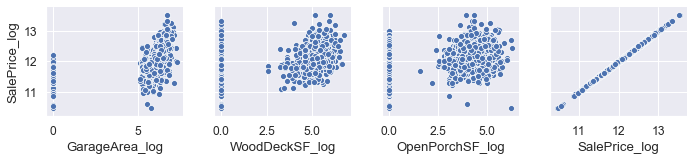

In [910]:
for i in range(0, len(df_num.columns), 4):
    sns.pairplot(data=df_num, x_vars=df_num.columns[i:i+4], y_vars=['SalePrice_log'])
plt.show(block=False)

Most of the 2D relationships we can spot here are linear (or close to), we knew of those before from computing the pearson correlations. 
## EDA for categorial features

We'll now look at the distribution of all categorial features, understant the connections between them, and the connection between each of them and <em>'SalePrice_log'</em> (our new target).
### Descriptive statistics

In [911]:
train_cat_features=train.select_dtypes(include=['object']).columns
train[train_cat_features].describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Bin_GarageArea_log,Bin_2ndFlrSF
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,2,3,4,4,2,5,3,25,...,6,6,3,4,5,5,9,6,2,2
top,20,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,TA,TA,Y,None,None,None,WD,Normal,0,1
freq,536,1151,1454,1369,925,1311,1459,1052,1382,225,...,1311,1326,1340,1453,1179,1406,1267,1198,1379,829


### Histograms
Now let's plot them all.

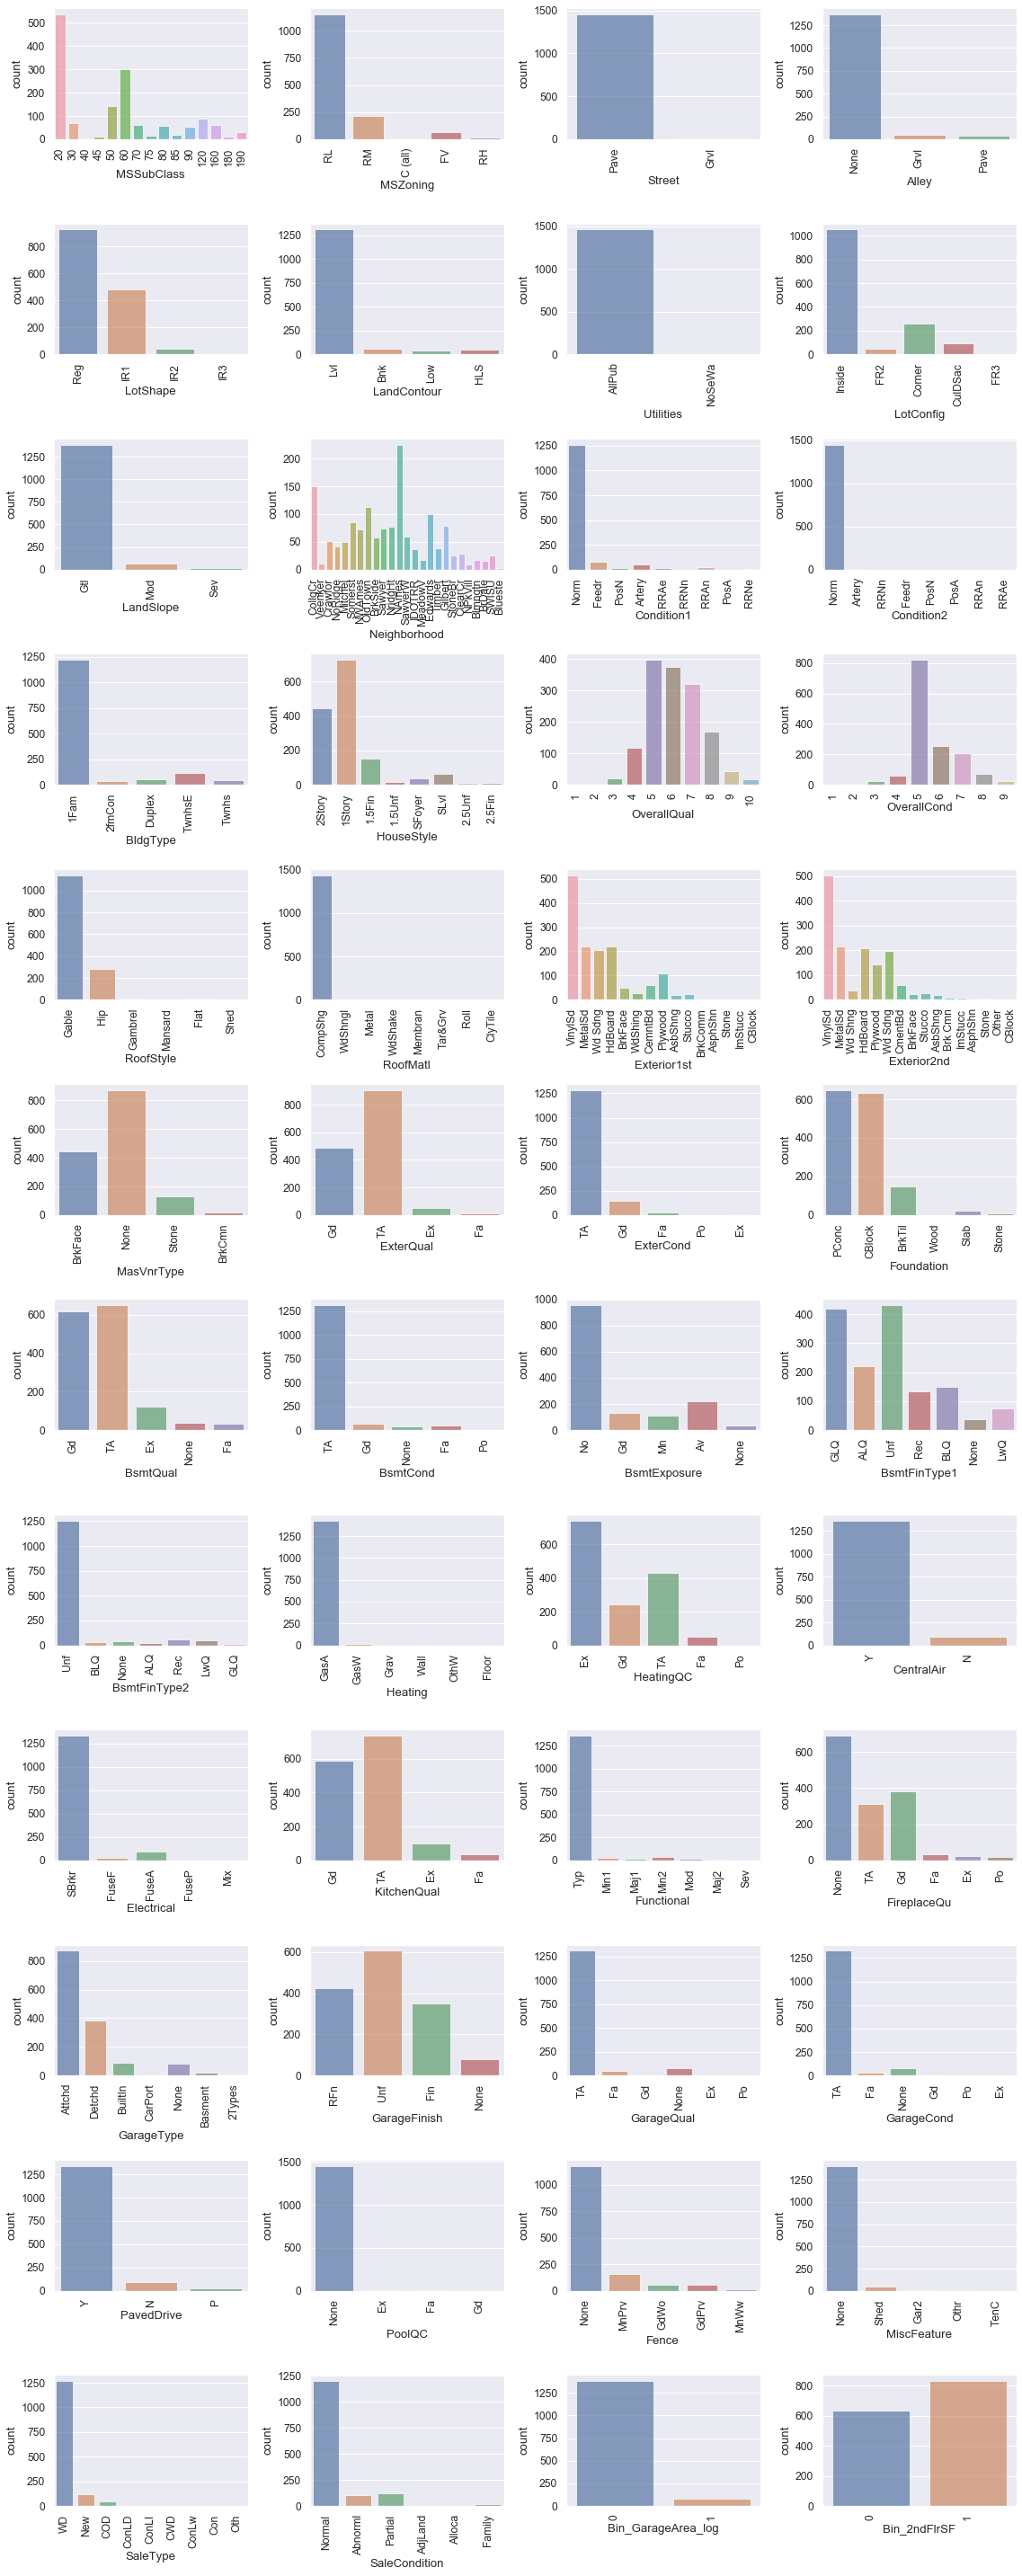

In [912]:
fig, axes=plt.subplots(round(len(train[train_cat_features].columns)/4), 4, figsize=(16, 40))
for i, ax in enumerate(fig.axes):
    if i<len(train[train_cat_features].columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=train[train_cat_features].columns[i], alpha=0.7, data=train[train_cat_features], ax=ax)
fig.tight_layout() 

We notice some feautres with one or more dominant categories. The ones with one doinant will probably not be relavent for our predictions, but can confuse the model. We'll combine categories in those cases.
Where the dominant category is on the verge of being singular, we can dispose those features.

In [913]:
#remove
remove_features=['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'CentralAir', 'Functional',
                 'Heating', 'PoolQC', 'MiscFeature', 'Bin_GarageArea_log']
train.drop(remove_features, axis=1, inplace=True)

#combine categories
train['LotConfig']=np.where((train['LotConfig']=='CulDSac')| (train['LotConfig']=='FR2')| (train['LotConfig']=='FR3'),
                            'Other', train['LotConfig'])
train['ExterQual']=np.where((train['ExterQual']=='Ex')| (train['ExterQual']=='Fa'),
                            'Other', train['ExterQual'])
train['GarageType']=np.where((train['GarageType']=='BuiltIn')| (train['GarageType']=='None')|
                             (train['GarageType']=='Basment')| (train['GarageType']=='CarPort')|
                             (train['GarageType']=='2Types'),'Other', train['GarageType'])
train['Foundation']=np.where((train['Foundation']=='Slab')| (train['Foundation']=='Stone')| (train['Foundation']=='Wood'),
                            'Other', train['Foundation'])
train['BsmtQual']=np.where((train['BsmtQual']=='None')| (train['BsmtQual']=='Fa'),
                            'Other', train['BsmtQual'])
train['FireplaceQu']=np.where((train['FireplaceQu']=='Fa')| (train['FireplaceQu']=='Ex')| (train['FireplaceQu']=='Po'),
                            'Other', train['FireplaceQu'])
train['MasVnrType']=np.where((train['MasVnrType']=='Stone')| (train['MasVnrType']=='BrkCmn'),
                            'Other', train['MasVnrType'])
train['HouseStyle']=np.where((train['HouseStyle']=='SLvl')| (train['HouseStyle']=='SFoyer')|
                             (train['HouseStyle']=='1.5Unf')| (train['HouseStyle']=='2.5Unf')|
                             (train['HouseStyle']=='2.5Fin'),'Other', train['HouseStyle'])

#create binary
train['IsRLMSZoning']=(train['MSZoning']=='RL')*1
train['IsLvlLandContour']=(train['LandContour']=='Lvl')*1
train['IsNormCondition1']=(train['Condition1']=='Norm')*1
train['Is1FamBldgType']=(train['BldgType']=='1Fam')*1
train['IsGableRoofStyle']=(train['RoofStyle']=='Gable')*1
train['IsTAExterCond']=(train['ExterCond']=='TA')*1
train['IsTABsmtCond']=(train['BsmtCond']=='TA')*1
train['IsFinBsmtFinType2']=(train['BsmtFinType2']!='Unf')*1
train['IsSBrkrElectrical']=(train['Electrical']=='SBrkr')*1
train['IsTAGarageQual']=(train['GarageQual']=='TA')*1
train['IsTAGarageCond']=(train['GarageCond']=='TA')*1
train['IsPavedDrive']=(train['PavedDrive']=='Y')*1
train['IsFence']=(train['Fence']!='None')*1
train['IsWDSaleType']=(train['SaleType']=='WD')*1
train['IsNormalSaleCondition']=(train['SaleCondition']=='Normal')*1

added_features=['IsRLMSZoning', 'IsLvlLandContour', 'IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 
                'IsTAExterCond', 'IsTABsmtCond','IsFinBsmtFinType2', 'IsSBrkrElectrical', 'IsTAGarageQual', 
                'IsTAGarageCond', 'IsPavedDrive', 'IsFence', 'IsWDSaleType', 'IsNormalSaleCondition']
for feat in added_features:
    train[feat]=train[feat].astype(object)

remove_features=['MSZoning', 'LandContour', 'Condition1', 'BldgType', 'RoofStyle', 'ExterCond', 'BsmtCond', 'BsmtFinType2',
                 'Electrical', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
train.drop(remove_features, axis=1, inplace=True)

tmp=train.pop(target)
train[target]=tmp
train_cat_features=train.select_dtypes(include=['object']).columns

### Connections between features & target
#### Chi-square test of independence
Chi-square test of independence checks if the is a connection between 2 nominal variables. Though within our categorial features we have both nominal and ordinal features, all ordinal features are nominal (the opposite is not true). Let's consider all categorial features for this part as nominal and perform the test. We will lose information, since We are ignoring the rank within the ordinal features, but for now we only care to search assosiations between features.
We will use the common value for alpha, 0.05, to decide in the matter.

In [914]:
tmp=train[train_cat_features].copy()
for i in range(0, len(tmp.columns)-1):
    H1=[]
    for j in range(i+1, len(tmp.columns)):
        cross=pd.crosstab(tmp[tmp.columns[i]], tmp[tmp.columns[j]])
        observed=[]
        for k in range(0, tmp[tmp.columns[i]].describe().at['unique']):
            observed.append(cross.iloc[k , 0:((tmp[tmp.columns[j]].describe().at['unique'])+1)].values)
        chi=stats.chi2_contingency(observed)
        if stats.chi2_contingency(observed)[1]<0.05:
            H1.append(tmp.columns[j])
    print("*The feature {i} is strongly connected with: {j} ".format(i=tmp.columns[i], j=H1))   

*The feature MSSubClass is strongly connected with: ['LotShape', 'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'Bin_2ndFlrSF', 'IsRLMSZoning', 'IsLvlLandContour', 'IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 'IsTAExterCond', 'IsTABsmtCond', 'IsFinBsmtFinType2', 'IsSBrkrElectrical', 'IsTAGarageQual', 'IsTAGarageCond', 'IsPavedDrive', 'IsFence', 'IsWDSaleType'] 
*The feature LotShape is strongly connected with: ['LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'IsRLMSZoning', 'IsLvlLandContour', 'IsNormCondition1', 'Is1FamBldgType', 'IsSBrkrElectrical', 'I

*The feature GarageType is strongly connected with: ['GarageFinish', 'Bin_2ndFlrSF', 'IsRLMSZoning', 'IsLvlLandContour', 'IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 'IsTAExterCond', 'IsTABsmtCond', 'IsSBrkrElectrical', 'IsTAGarageQual', 'IsTAGarageCond', 'IsPavedDrive', 'IsFence', 'IsWDSaleType', 'IsNormalSaleCondition'] 
*The feature GarageFinish is strongly connected with: ['Bin_2ndFlrSF', 'IsRLMSZoning', 'IsLvlLandContour', 'IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 'IsTAExterCond', 'IsTABsmtCond', 'IsFinBsmtFinType2', 'IsSBrkrElectrical', 'IsTAGarageQual', 'IsTAGarageCond', 'IsPavedDrive', 'IsFence', 'IsWDSaleType', 'IsNormalSaleCondition'] 
*The feature Bin_2ndFlrSF is strongly connected with: ['IsRLMSZoning', 'IsNormCondition1', 'IsGableRoofStyle', 'IsFinBsmtFinType2', 'IsPavedDrive', 'IsWDSaleType', 'IsNormalSaleCondition'] 
*The feature IsRLMSZoning is strongly connected with: ['Is1FamBldgType', 'IsGableRoofStyle', 'IsTAExterCond', 'IsFinBsmtFinType

As we can see, there are strong connections between a lot of the features.

The next step will be to search for connections between the features and the target. Here we need to separate the nominal features from the ordinal ones since the methods are different. We will search for the data description to decide if a categorial feature is nominal or ordinal.

In [915]:
train_nom_features=['MSSubClass', 'LotConfig', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'ExterQual', 'Foundation', 'FireplaceQu', 'GarageType', 'Bin_2ndFlrSF', 'IsRLMSZoning', 
                    'IsLvlLandContour', 'IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 'IsTAExterCond', 
                    'IsTABsmtCond', 'IsSBrkrElectrical', 'IsTAGarageQual', 'IsTAGarageCond', 'IsFence', 'IsWDSaleType', 
                    'IsNormalSaleCondition']
train_ord_features=[item for item in train_cat_features if item not in train_nom_features]

#### Spearman's rank correlation coefficient
A nonparametric measure, assesses how well the relationship between two variables can be described using a monotonic function. Spearman's correlation is appropriate for both continuous and discrete ordinal variables.
First we'll need to create a dictionary that defines the rank for each feature. 

In [916]:
LotShape={'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3}
BsmtQual={'Other':0, 'TA':1, 'Gd':2, 'Ex':3}
BsmtExposure={'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
BsmtFinType1={'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
GarageFinish={'None':0, 'Unf':1, 'RFn':2, 'Fin':3}
feat_0_4=['HeatingQC', 'KitchenQual']
dict_0_4={'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}

Now we'll convert the values in each ordinal feautre according to the dictionary.

In [917]:
train['LotShape']=train['LotShape'].map(LotShape).astype(int)
train['BsmtQual']=train['BsmtQual'].map(BsmtQual).astype(int)
train['BsmtExposure']=train['BsmtExposure'].map(BsmtExposure).astype(int)
train['BsmtFinType1']=train['BsmtFinType1'].map(BsmtFinType1).astype(int)
train['GarageFinish']=train['GarageFinish'].map(GarageFinish).astype(int)
for feature in feat_0_4:
    train[feature]=train[feature].map(dict_0_4).astype(int)
train['OverallQual']=train['OverallQual'].astype(int)
train['OverallCond']=train['OverallCond'].astype(int)
train['IsFinBsmtFinType2']=train['IsFinBsmtFinType2'].astype(int)
train['IsPavedDrive']=train['IsPavedDrive'].astype(int)

Finally we can calculate the correlation between the ordinal features and the target.

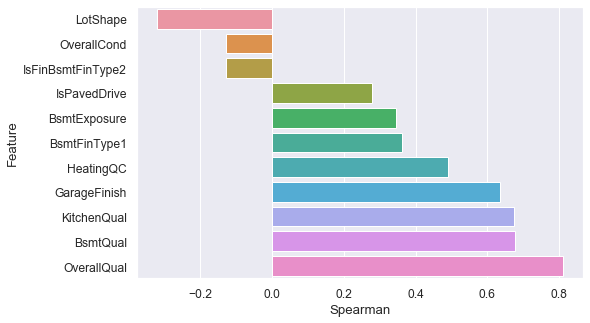

In [918]:
spear=pd.DataFrame()
spear['Feature']=train_ord_features
spear['Spearman']=[train[feature].corr(train['SalePrice_log'], 'spearman') for feature in train_ord_features]
spear=spear.sort_values('Spearman')
plt.figure(figsize=(8, 5))
sns.barplot(data=spear, y='Feature', x='Spearman')
plt.show(block=False)

We can spot a number of features strongly correlated with <em>'SalePrice_log'</em>, most of them rank the general quality of certain parts of the property. The highest connection was found with the propetys' rate of the overall material and finish.
We were surprised to find some negative correlations, but they were relative small.
#### One-way ANOVA's $R^2$
In order to evaluate the relationship between the nominal features and the target, we'll perform a one-way ANOVA test between each of the features and the target, then extract the $R^2$ value. The normality assumption needed for the test only refers to the statistics' distribution, whitout it we can't make a statistical inference, but the calculation and meaning of $R^2$ is the same and isn't distribution related.

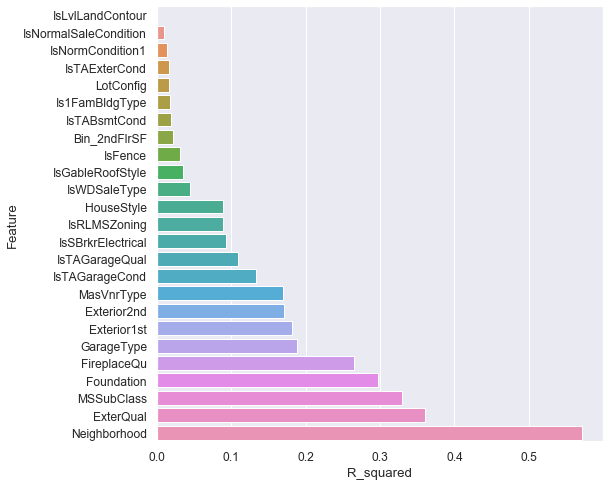

In [919]:
rqsuare=pd.DataFrame()
rqsuare['Feature']=train_nom_features
rqsuare['R_squared']=[ols('SalePrice_log ~ {feature}'.format(feature=feature), data=train).fit().rsquared 
                      for feature in train_nom_features]
rqsuare=rqsuare.sort_values('R_squared')
plt.figure(figsize=(8, 8))
sns.barplot(data=rqsuare, y='Feature', x='R_squared')
plt.show(block=False)

The highest correlation we found is between <em>'SalePrice_log'</em> and <em>'Neighborhood'</em>.
#### Feature-target plots
Lastly, we want to look at <em>'SalePrice_log'</em>'s distribution with respect to each of the categorial features.

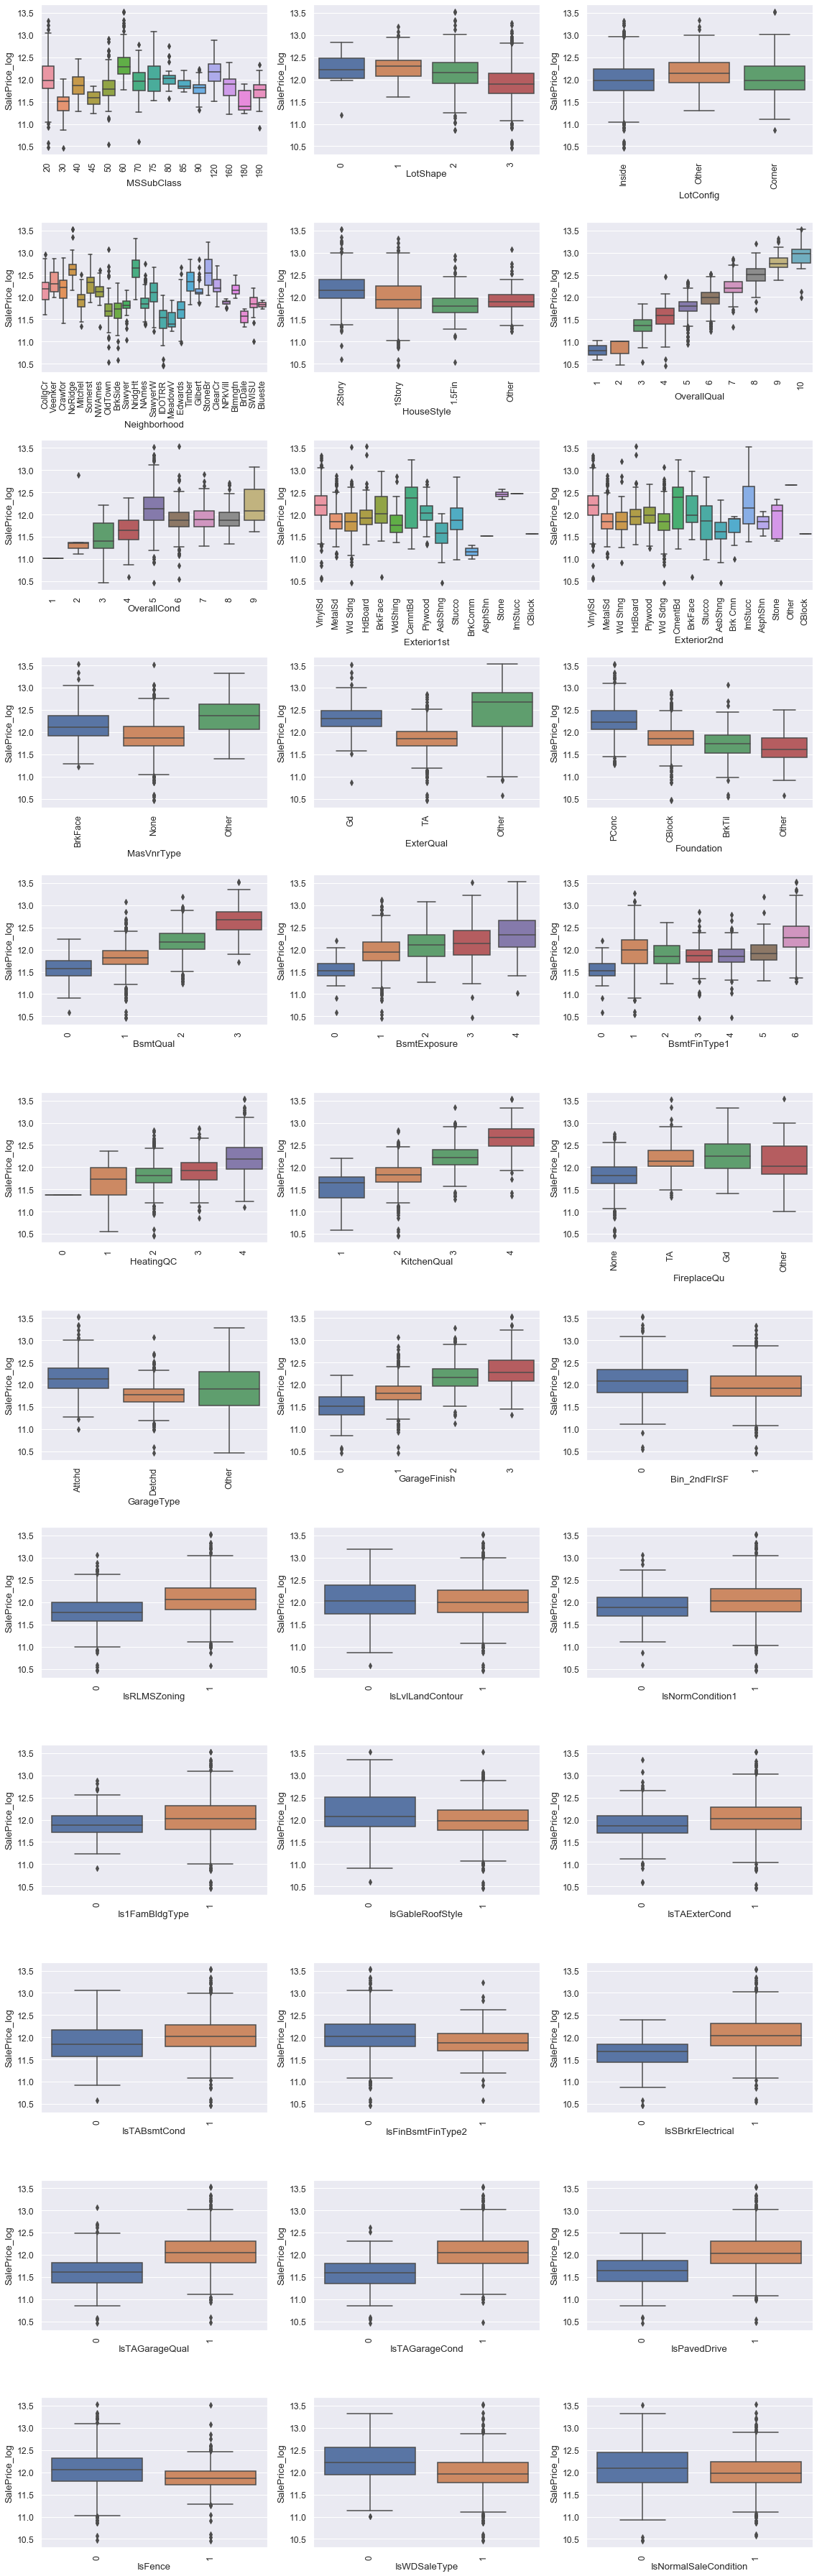

In [920]:
df_cat=train[train_cat_features].copy()
df_cat['SalePrice_log']=train[target]
fig, axes=plt.subplots(round(len(df_cat.columns)/3), 3, figsize=(16, 50))
for i, ax in enumerate(fig.axes):
    if i<(len(df_cat.columns)-1):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.boxplot(x=df_cat.columns[i], y=df_cat['SalePrice_log'], data=df_cat, ax=ax)
fig.tight_layout() 

With some features, <em>'SalePrice_log'</em> seem to change with respect to the different categories more than with others. Most of those we already recognized from the correlations we computed.
## Modeling
### Preparations
In order to model the data, we first need to encode all nominal variables in our possession (except for binary ones). We'll use the 'One-Hot encoding' approach, the basic strategy is to convert each category value (except one) into a new column and assign 1/0 (True/False) value to the column.
Note that after we mapped all ordinal features, we converted them to numericals, so we allready delt with them.

In [921]:
bin_features=['Bin_2ndFlrSF', 'IsRLMSZoning', 'IsLvlLandContour','IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 
              'IsTAExterCond', 'IsTABsmtCond', 'IsFinBsmtFinType2','IsSBrkrElectrical', 'IsTAGarageQual', 'IsTAGarageCond', 
              'IsPavedDrive','IsFence', 'IsWDSaleType', 'IsNormalSaleCondition']

for feat in bin_features:
    train[feat]=train[feat].astype('uint8')
    
train=create_dummies(train, target, True)

### Models
We'll choose to run 3 models. the first one will be a linear model (as the basic model), the second will be decision-tree based model, and the third will also be a decision-tree based model but more sophisticated:
<ol>
    <li>Lasso regression</li>
    <li>Random forest</li>
    <li>XGboost</li>
</ol>
In order to ensure that we find the best model possible from all options and avoid overfitting, We will use cross validation and perform hyperparameter tunning in all models.

In [922]:
cv_scores_lr=[]
cv_scores_rf=[]
cv_scores_xgb=[]

indx=1
kf=model_selection.KFold(n_splits=5, shuffle=True)

for train_indx, test_indx in kf.split(range(train.shape[0])):
    print("CV iteration: {CV_indx} of 5".format(CV_indx=indx))
    indx=indx+1
    
    df_train, df_test=train.iloc[train_indx, :], train.iloc[test_indx, :]
    train_X, train_Y=df_train.drop(target, inplace=False, axis=1), df_train.loc[:, target]
    test_X, test_Y=df_test.drop(target, inplace=False, axis=1), df_test.loc[:, target]

    #lasso regression
    preds, lr_model=run_lr(train_X, train_Y, test_X)
    cv_scores_lr.append(mean_squared_error(test_Y, preds))

    #random forest
    preds, rf_model=run_rf(train_X, train_Y, test_X)
    cv_scores_rf.append(mean_squared_error(test_Y, preds))
    
    #xgboost
    preds, xgb_model=run_xgb(train_X, train_Y, test_X)
    cv_scores_xgb.append(mean_squared_error(test_Y, preds))

CV iteration: 1 of 5
LR GridSearchCV took 4.83 seconds.
RF RandomizedSearchCV took 125.35 seconds.
XGB RandomizedSearchCV took 44.28 seconds.
CV iteration: 2 of 5
LR GridSearchCV took 0.20 seconds.
RF RandomizedSearchCV took 51.08 seconds.
XGB RandomizedSearchCV took 31.99 seconds.
CV iteration: 3 of 5
LR GridSearchCV took 0.18 seconds.
RF RandomizedSearchCV took 62.49 seconds.
XGB RandomizedSearchCV took 36.63 seconds.
CV iteration: 4 of 5
LR GridSearchCV took 0.15 seconds.
RF RandomizedSearchCV took 86.07 seconds.
XGB RandomizedSearchCV took 39.10 seconds.
CV iteration: 5 of 5
LR GridSearchCV took 0.14 seconds.
RF RandomizedSearchCV took 93.29 seconds.
XGB RandomizedSearchCV took 33.72 seconds.


In [923]:
print("Average LR mean_squared_error: {avg_lr:.4f}".format(avg_lr=np.mean(cv_scores_lr)))
print("Average RF mean_squared_error: {avg_rf:.4f}".format(avg_rf=np.mean(cv_scores_rf)))
print("Average XGB mean_squared_error: {avg_xgb:.4f}".format(avg_xgb=np.mean(cv_scores_xgb)))

Average LR mean_squared_error: 0.0181
Average RF mean_squared_error: 0.0202
Average XGB mean_squared_error: 0.0171


It seems the best model out of the three is XGboost. Before choosing a model for prediction, since there are a lot of features and we don't believe all of them have an impact on 'SalePrice_log', we will use Lasso regression for feature selection (it shrinks unimportant feature's coefficients to absolute 0), then run the other models. This path may lead to a smaller error.

In [924]:
features=train.columns[0 : -1]
X=train[features]
Y=train[target]
Lasso_model=LassoCV(alphas=[1, 0.1, 0.01, 0.001, 0.0005])
Lasso_model.fit(X, Y)
coef=pd.Series(Lasso_model.coef_, index=X.columns)
print("Lasso picked {i} variables and eliminated the other {j} variables".format(i=sum(coef != 0), j=sum(coef == 0)))
remove_feat=coef[coef==0].index[:].tolist()
feat=[item for item in train.columns if item not in remove_feat]
new_train=train[feat].copy()

cv_scores_rf=[]
cv_scores_xgb=[]

indx=1
kf=model_selection.KFold(n_splits=5, shuffle=True)

for train_indx, test_indx in kf.split(range(new_train.shape[0])):
    print("CV iteration: {CV_indx} of 5".format(CV_indx=indx))
    indx=indx+1
    
    df_train, df_test=new_train.iloc[train_indx, :], new_train.iloc[test_indx, :]
    train_X, train_Y=df_train.drop(target, inplace=False, axis=1), df_train.loc[:, target]
    test_X, test_Y=df_test.drop(target, inplace=False, axis=1), df_test.loc[:, target]

    #random forest
    preds, rf_model=run_rf(train_X, train_Y, test_X)
    cv_scores_rf.append(mean_squared_error(test_Y, preds))
    
    #xgboost
    preds, xgb_model=run_xgb(train_X, train_Y, test_X)
    cv_scores_xgb.append(mean_squared_error(test_Y, preds))

Lasso picked 82 variables and eliminated the other 61 variables
CV iteration: 1 of 5
RF RandomizedSearchCV took 20.12 seconds.
XGB RandomizedSearchCV took 21.73 seconds.
CV iteration: 2 of 5
RF RandomizedSearchCV took 19.16 seconds.
XGB RandomizedSearchCV took 22.37 seconds.
CV iteration: 3 of 5
RF RandomizedSearchCV took 31.93 seconds.
XGB RandomizedSearchCV took 20.86 seconds.
CV iteration: 4 of 5
RF RandomizedSearchCV took 43.89 seconds.
XGB RandomizedSearchCV took 21.35 seconds.
CV iteration: 5 of 5
RF RandomizedSearchCV took 19.49 seconds.
XGB RandomizedSearchCV took 20.25 seconds.


In [925]:
print("Average RF mean_squared_error: {avg_rf:.4f}".format(avg_rf=np.mean(cv_scores_rf)))
print("Average XGB mean_squared_error: {avg_xgb:.4f}".format(avg_xgb=np.mean(cv_scores_xgb)))

Average RF mean_squared_error: 0.0197
Average XGB mean_squared_error: 0.0169


The best model is still XGboost, the mean error decreased. In order to get the model for prediction, we'll now run XGboost without the external Kfold.

In [926]:
X=new_train.drop(target, inplace=False, axis=1)
Y=new_train.loc[:, target]
    
clf=xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, silent=True, nthread=1)

params={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}

xgb_random=RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=5, n_jobs=1, 
                              scoring='neg_mean_squared_error', cv=5)

start=time()

xgb_random.fit(X, Y)

print("XGB RandomizedSearchCV took %.2f seconds."% (time()-start))

xgb_best_model=xgb_random.best_estimator_

XGB RandomizedSearchCV took 88.76 seconds.


## On my way to prediction
### Load and prepare test data

The same procedures performed to the train set will be performed here.

Our strategy regarding filling missing value in the test set will be as follows:
<ul>
    <li>Categorical features- fill with the most frequent value of the feature in the train set.</li>
    <li>Numerical features- </li>
    <ul>
        <li>if a manipulation was decided above, we'll do the same thing here.</li>
        <li>if not, fill with the median of the feature in the train set (doesn't change the feature's distribution).</li>
    </ul>
</ul>

In [941]:
test=load_data('test.csv')

#validate feature's dtypes
test['MSSubClass']=test['MSSubClass'].astype(object)
test['OverallQual']=test['OverallQual'].astype(object)
test['OverallCond']=test['OverallCond'].astype(object)

#fill missing values
test_cat_features=test.select_dtypes(include = ['object']).columns
test_num_features=test._get_numeric_data().columns
missing_features=test.columns[test.isnull().any()]
test_missing_cat=[item for item in test_cat_features if item in missing_features]
test_missing_num=[item for item in test_num_features if item in missing_features]
##categorical features
for feat in test_missing_cat:
    test.loc[test[feat].isnull(), feat]=train_copy[feat].describe().at['top']
#numerical features  
test['SqrtLotArea']=np.sqrt(test['LotArea'])
test['LotFrontage']=np.where(test['LotFrontage'].isnull(), test['SqrtLotArea'], test['LotFrontage'])
test.drop('SqrtLotArea', axis=1, inplace=True)
for feat in test_missing_num:
    med=train_copy[feat].median()
    test.loc[test[feat].isnull(), feat]=med
    
#log transformation to numerical features
features=['LotFrontage', 'LotArea', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
test, transformed_features=log_transformation(test, features, target, False)

#create binary features
features=['GarageArea_log', '2ndFlrSF']
test=create_bin(test, features, target, False)

#combine categories
test['LotConfig']=np.where((test['LotConfig']=='CulDSac')| (test['LotConfig']=='FR2')| (test['LotConfig']=='FR3'),'Other', 
                           test['LotConfig'])
test['ExterQual']=np.where((test['ExterQual']=='Ex')| (test['ExterQual']=='Fa'), 'Other', test['ExterQual'])
test['GarageType']=np.where((test['GarageType']=='BuiltIn')| (test['GarageType']=='None')| (test['GarageType']=='Basment')| 
                            (test['GarageType']=='CarPort')| (test['GarageType']=='2Types'),'Other', test['GarageType'])
test['Foundation']=np.where((test['Foundation']=='Slab')| (test['Foundation']=='Stone')| (test['Foundation']=='Wood'), 
                            'Other', test['Foundation'])
test['BsmtQual']=np.where((test['BsmtQual']=='None')| (test['BsmtQual']=='Fa'), 'Other', test['BsmtQual'])
test['FireplaceQu']=np.where((test['FireplaceQu']=='Fa')| (test['FireplaceQu']=='Ex')| (test['FireplaceQu']=='Po'),'Other',
                             test['FireplaceQu'])
test['MasVnrType']=np.where((test['MasVnrType']=='Stone')| (test['MasVnrType']=='BrkCmn'), 'Other', test['MasVnrType'])
test['HouseStyle']=np.where((test['HouseStyle']=='SLvl')| (test['HouseStyle']=='SFoyer')| (test['HouseStyle']=='1.5Unf')|
                            (test['HouseStyle']=='2.5Unf')| (test['HouseStyle']=='2.5Fin'),'Other', test['HouseStyle'])

#create binary
test['IsRLMSZoning']=(test['MSZoning']=='RL')*1
test['IsLvlLandContour']=(test['LandContour']=='Lvl')*1
test['IsNormCondition1']=(test['Condition1']=='Norm')*1
test['Is1FamBldgType']=(test['BldgType']=='1Fam')*1
test['IsGableRoofStyle']=(test['RoofStyle']=='Gable')*1
test['IsTAExterCond']=(test['ExterCond']=='TA')*1
test['IsTABsmtCond']=(test['BsmtCond']=='TA')*1
test['IsFinBsmtFinType2']=(test['BsmtFinType2']!='Unf')*1
test['IsSBrkrElectrical']=(test['Electrical']=='SBrkr')*1
test['IsTAGarageQual']=(test['GarageQual']=='TA')*1
test['IsTAGarageCond']=(test['GarageCond']=='TA')*1
test['IsPavedDrive']=(test['PavedDrive']=='Y')*1
test['IsFence']=(test['Fence']!='None')*1
test['IsWDSaleType']=(test['SaleType']=='WD')*1
test['IsNormalSaleCondition']=(test['SaleCondition']=='Normal')*1
added_features=['IsRLMSZoning', 'IsLvlLandContour', 'IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 
                'IsTAExterCond', 'IsTABsmtCond','IsFinBsmtFinType2', 'IsSBrkrElectrical', 'IsTAGarageQual', 
                'IsTAGarageCond', 'IsPavedDrive', 'IsFence', 'IsWDSaleType', 'IsNormalSaleCondition']
for feat in added_features:
    test[feat]=test[feat].astype(object)

#convert ordinal feautres to numerical according to dictionary
test['LotShape']=test['LotShape'].map(LotShape).astype(int)
test['BsmtQual']=test['BsmtQual'].map(BsmtQual).astype(int)
test['BsmtExposure']=test['BsmtExposure'].map(BsmtExposure).astype(int)
test['BsmtFinType1']=test['BsmtFinType1'].map(BsmtFinType1).astype(int)
test['GarageFinish']=test['GarageFinish'].map(GarageFinish).astype(int)
for feature in feat_0_4:
    test[feature]=test[feature].map(dict_0_4).astype(int)
test['OverallQual']=test['OverallQual'].astype(int)
test['OverallCond']=test['OverallCond'].astype(int)
test['IsFinBsmtFinType2']=test['IsFinBsmtFinType2'].astype(int)
test['IsPavedDrive']=test['IsPavedDrive'].astype(int)

#convert binary features to unit8 dtype
bin_features=['Bin_2ndFlrSF', 'IsRLMSZoning', 'IsLvlLandContour','IsNormCondition1', 'Is1FamBldgType', 'IsGableRoofStyle', 
              'IsTAExterCond', 'IsTABsmtCond', 'IsFinBsmtFinType2','IsSBrkrElectrical', 'IsTAGarageQual', 'IsTAGarageCond', 
              'IsPavedDrive','IsFence', 'IsWDSaleType', 'IsNormalSaleCondition']
for feat in bin_features:
    test[feat]=test[feat].astype('uint8')
    
#create dummy variables prior to prediction    
test=create_dummies(test, target, False)

#discard all unnecessary features 
feat_to_use=new_train.columns[0 : -1]
test=test[feat_to_use]

### Predict

In [944]:
test_prediction=xgb_best_model.predict(test)
prediction=np.exp(test_prediction)
np.savetxt('prediction_file.txt', prediction, delimiter=',', fmt='%d')